In [1]:
import sys
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel
from wordcloud import WordCloud
from collections import defaultdict
import json
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

In [2]:
########### Function to get original word from stemmed word ##########
def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}

    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms

# function to remove emoji
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

In [3]:
############## file reading and preprocessing ####################33

stemmer = PorterStemmer() # Stemmer for reducing terms to root form

stemmed_corpus = []       # For storing the stemmed tokens

original_corpus = []      # For storing the non-stemmed tokens

data_path = "Facebook_Data.json"

tokenizer = RegexpTokenizer(r'\w+')
with open(data_path, "r", encoding = "UTF-8") as json_file:
    data = json.load(json_file)
    for obj in data:
        text = " ".join(obj['text']).lower()

        demoji = remove_emoji(text)
        tokens = tokenizer.tokenize(demoji) #extract tokens from the text
        
        stemmed = [stemmer.stem(token) for token in tokens] #stem the tokens

        stemmed_corpus.append(stemmed) #store stemmed document

        original_corpus.append(tokens) #store original document
        if obj['comments'] != []:
            for comment in obj['comments']:
                text = " ".join(obj['text']).lower()

                demoji = remove_emoji(text)
                tokens = tokenizer.tokenize(demoji) #extract tokens from the text
                
                stemmed = [stemmer.stem(token) for token in tokens] #stem the tokens

                stemmed_corpus.append(stemmed) #store stemmed document

                original_corpus.append(tokens) #store original document

print("Total posts and comments:", len(stemmed_corpus))
dictionary = Dictionary(stemmed_corpus) # build the dictionary

counts = get_common_surface_form(original_corpus,stemmer) # get surface form

Total posts and comments: 4080


In [4]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['https', 'http', "com", "facebook", "www", "black", "live", "matter", "the", "blm", "like", "want", "php", "youtu", "youtube", "watch", "cheick", "hamidou", "ouedraogo", "comment", "white","people","live","go","one","need", "must", "so", "sort", "twitter", "was"]

stop_words_stemmed = [stemmer.stem(token) for token in stop_words]

stemmed_corpus_filtered = []
counter = 0
for stemmed_document in stemmed_corpus:
    toAppend = []

    for token in stemmed_document:
        if token not in stop_words_stemmed:
            toAppend.append(token)
            counter += 1
    stemmed_corpus_filtered.append(toAppend)

print("Words Filtered:", counter)
print("Stop Words Filtered")

Words Filtered: 158858
Stop Words Filtered


In [5]:
# Convert to vector corpus

vectors = [dictionary.doc2bow(text) for text in stemmed_corpus_filtered]

# Train TF-IDF model

tfidf = TfidfModel(vectors)

# Transform the corpus to tf-idf vectors

corpus_tfidf = tfidf[vectors]

# Train the LDA model

lda = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5)

# for pair in lda.show_topic(0,topn=1000):
#     print(pair)

# Extract 1000 terms from an arbitrarily chosen topic

print("Model Trained")

Model Trained


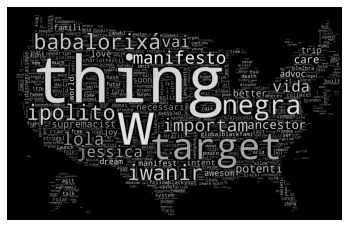

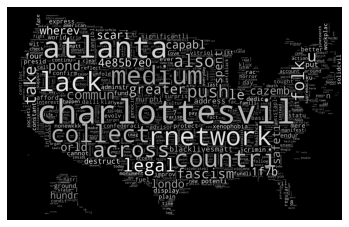

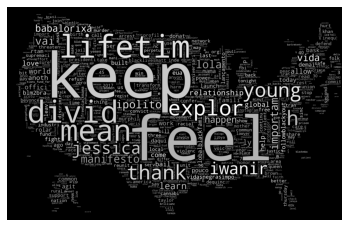

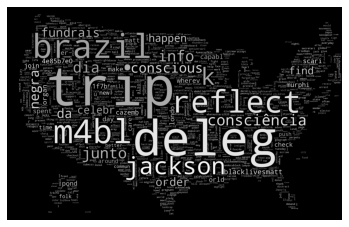

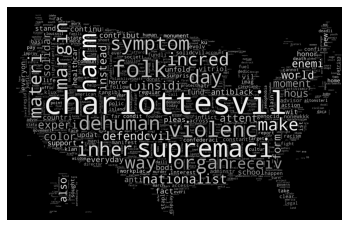

In [6]:
# To Generate word cloud
#  mask = np.array(Image.open("../usaMap2.jpg"))

# for i in range(5):
#     weights = [(pair[0], pair[1]) for pair in lda.show_topic(i, topn=1000)]

#     wc = WordCloud(
#         background_color="black",
#         max_words=2000,
#         width=3000,
#         height=2000,
#         mask = mask,
#         color_func=grey_color_func
#     )

#     # Generate the cloud

#     # print (dict(weights))
#     wc.generate_from_frequencies(dict(weights))

#     plt.imshow(wc)
#     plt.axis('off')
#     plt.savefig('FacebookTopicModeling'+str(i)+'.png', dpi=300)
#     plt.show()

# # print("Word Cloud Generated")

In [7]:
########## Fill in this list to see the original words ######

# words = ["thing", "negra", "w"]

# for word in words:
#     print(counts[word])

things
negra
w


In [6]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [8]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, vectors, dictionary)
out_file = "LDAModel.html"
pyLDAvis.save_html(LDAvis_prepared,out_file)